[*********************100%***********************]  93 of 93 completed
C:\Users\chris\AppData\Local\Temp\ipykernel_16508\2966718358.py:40: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = adj_close.pct_change().dropna()


📈 Estimated μ (return): 11.37% | σ (volatility): 30.86%


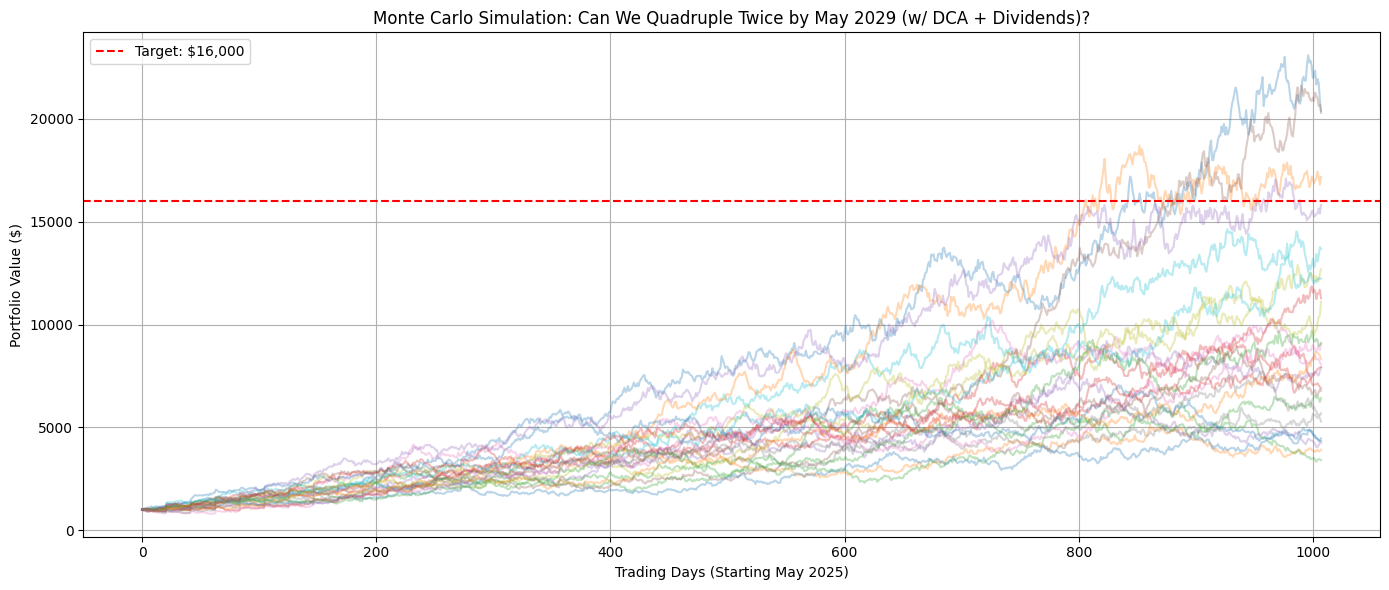

🎯 Probability of reaching $16,000 in 4 years: 2.00%
🔻 5th percentile: $3,716 | 🔺 95th percentile: $13,625


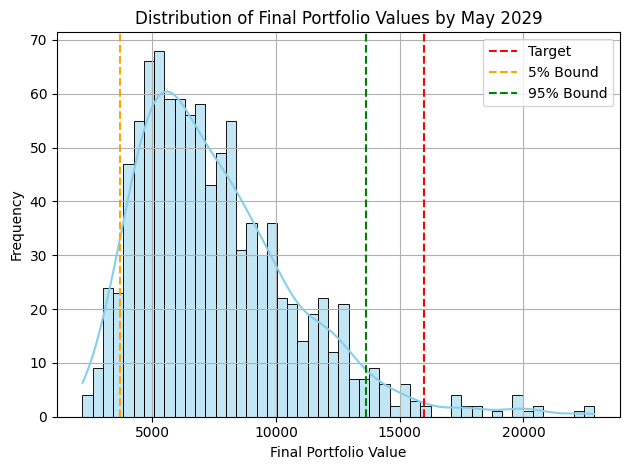

In [4]:
# 📦 Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

# 🎯 Simulation Goal: Multi-year doubling target (to May 2029) with $100/month DCA and dividend reinvestment
initial_investment = 1000
monthly_contribution = 100
years = 4
target_value = initial_investment * (2 ** years)  # $1k → $2k → $4k → $8k → $16k
trading_days = 252 * years
simulations = 1000

# 🔍 Use historical data to estimate mu and sigma
# Choose broad-market ETFs and stocks with rich data history
tickers = ["SCHD", "SWPPX", "SCHG", "QQQM", "PLTR", "MSTR", "SOFI", "MSFT", "BRK-B", "GOOG", "JPM", "MRK", "LULU", "UNH",
 "QQQ", "VTI", "SPY", "IVV", "DIA", "IWM", "VT", "VOO", "SPLG", "RSP",
 "XLF", "XLK", "XLY", "XLP", "XLV", "XLE", "XLU", "XLI", "XLB", "VNQ",
 "AAPL", "NVDA", "AMD", "META", "TSLA", "AMZN", "CRM", "GOOGL", "ORCL", "AVGO",
 "ADBE", "SNOW", "SHOP", "INTU", "PANW", "ZS", "NET", "COIN", "DOCU",
 "BAC", "WFC", "GS", "MS", "C", "TFC", "USB", "SCHW", "PGR", "CBRE",
 "BA", "CAT", "DE", "HON", "GE", "NOC", "RTX", "XOM", "CVX", "FCX",
 "PFE", "JNJ", "ABBV", "LLY", "BMY", "ZBH", "ISRG", "TMO", "MDT", "GILD",
 "WMT", "COST", "HD", "LOW", "TGT", "SBUX", "MCD", "KO", "PEP", "NKE"]

start_date = "2010-01-01"
end_date = "2025-04-30"
raw_data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker', auto_adjust=True)

# Extract and clean adjusted close prices
adj_close = pd.DataFrame()
for ticker in tickers:
    try:
        adj_close[ticker] = raw_data[ticker]['Close']
    except:
        continue
returns = adj_close.pct_change().dropna()

# Estimate mu and sigma from historical data
mu = returns.mean().mean() * 252
sigma = returns.std().mean() * np.sqrt(252)
print(f"📈 Estimated μ (return): {mu:.2%} | σ (volatility): {sigma:.2%}")

# 🧠 Monte Carlo Simulation (GBM + DCA + Dividends)
np.random.seed(42)
dt = 1 / 252
days_per_month = 21  # approx. trading days in a month
dividend_yield_annual = 0.015  # assume 1.5% yield

paths = np.zeros((trading_days, simulations))
paths[0] = initial_investment

for t in range(1, trading_days):
    rand = np.random.normal(0, 1, simulations)
    growth = np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rand)
    paths[t] = paths[t - 1] * growth

    # Add monthly DCA every ~21 trading days
    if t % days_per_month == 0:
        paths[t] += monthly_contribution

    # Reinvest dividends daily
    dividend_daily = (1 + dividend_yield_annual) ** (dt) - 1
    paths[t] *= (1 + dividend_daily)

# 📊 Plot Monte Carlo Sample Paths
plt.figure(figsize=(14, 6))
plt.plot(paths[:, :25], alpha=0.3)
plt.axhline(target_value, color='red', linestyle='--', label=f'Target: ${target_value:,.0f}')
plt.title("Monte Carlo Simulation: Can We Quadruple Twice by May 2029 (w/ DCA + Dividends)?")
plt.xlabel("Trading Days (Starting May 2025)")
plt.ylabel("Portfolio Value ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 📈 Distribution & Confidence Bands
final_values = paths[-1]
probability = np.mean(final_values >= target_value) * 100
lower_bound = np.percentile(final_values, 5)
upper_bound = np.percentile(final_values, 95)

print(f"🎯 Probability of reaching ${target_value:,.0f} in {years} years: {probability:.2f}%")
print(f"🔻 5th percentile: ${lower_bound:,.0f} | 🔺 95th percentile: ${upper_bound:,.0f}")

sns.histplot(final_values, bins=50, kde=True, color='skyblue')
plt.axvline(target_value, color='red', linestyle='--', label='Target')
plt.axvline(lower_bound, color='orange', linestyle='--', label='5% Bound')
plt.axvline(upper_bound, color='green', linestyle='--', label='95% Bound')
plt.title("Distribution of Final Portfolio Values by May 2029")
plt.xlabel("Final Portfolio Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
